In [441]:
from seq2seq import Data
import keras
from keras import layers
from requests import head
from tqdm import tqdm
import tensorflow as tf
from keras.utils import plot_model, to_categorical, pad_sequences
import numpy as np

## import fixed index
from thai_romanize_util import THAI2INDEX, ROMAN2INDEX 

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from IPython.display import Image, display_png
import pandas as pd

In [1]:
def PositionalEncoding(input_tensor, n=10000) -> tf.Tensor:
    """
    return matrix of Positional Encoding P_kj (length, emb_dim)
    P(k, 2i) = sin(k/n^(2i/d))
    P(k, 2i+1) = cos(k/n^(2i/d))
    
    k : position of an object in the input sequence
    d : dimension of the output embedding space
    n : user-defined scalar, set to 10,000 by the authors of Attention Is All You Need.
    """
    input_dtype = input_tensor.dtype
    _, seq_len, emb_dim = input_tensor.shape
    batch_size = tf.unstack(tf.shape(input_tensor))[0] # must tf.unstack because batch_size is None
    P = np.zeros((seq_len, emb_dim)) # create empty matrix 
    for k in range(seq_len):
        for i in np.arange(int(emb_dim/2)):
            denominator = np.power(n, 2*i/emb_dim)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    P = tf.convert_to_tensor(P, dtype=input_dtype) # convert ndarray to tf.tensor
    P = tf.tile(tf.expand_dims(P, axis=0), [batch_size, 1, 1]) # tile the position matrix by batch-size
    return P + input_tensor # add position to original tensor

class SourceTargetAttention():
    def __init__(self, seq_len_query, seq_len_memory, emb_dim=256, head_num=8, dropout_rate=0.2, nth=1, en_or_de='D'):
        self.seq_len_query = seq_len_query
        self.seq_len_memory = seq_len_memory
        self.emb_dim = emb_dim  # dimension of embedding and dense
        self.split_dim = emb_dim // head_num  # dimension after split into multi heads 
        self.head_num = head_num
        self.nth = nth
        assert emb_dim % head_num == 0, ValueError('emb_dim must be multiple of head_num')
        
        ### LAYERS ###
        self.layer_Q = layers.Dense(self.emb_dim, activation='relu', name=f'Query_{en_or_de}{nth}') # (batch, Q_length, emb_dim) -> (batch, Q_length, emb_dim)
        self.layer_K = layers.Dense(self.emb_dim, activation='relu', name=f'Key_{en_or_de}{nth}')
        self.layer_V = layers.Dense(self.emb_dim, activation='relu', name=f'Value_{en_or_de}{nth}')
        self.layer_splitQ = layers.Lambda(self._split_head, output_shape=(head_num, self.seq_len_query, self.split_dim), name=f'SplitHeadQ_{en_or_de}{nth}')  # (batch, Q_length, emb_dim) -> (batch, head_num, Q_length, emb_dim//head_num)
        self.layer_splitK = layers.Lambda(self._split_head, output_shape=(head_num, self.seq_len_memory, self.split_dim), name=f'SplitHeadK_{en_or_de}{nth}') # (batch, M_length, emb_dim) -> (batch, head_num, M_length, emb_dim//head_num)
        self.layer_splitV = layers.Lambda(self._split_head, output_shape=(head_num, self.seq_len_memory, self.split_dim), name=f'SplitHeadV_{en_or_de}{nth}') # (batch, M_length, emb_dim) -> (batch, head_num, M_length, emb_dim//head_num)
        self.layer_dotQK = layers.Lambda(self._dot_QK, output_shape=(head_num, self.seq_len_query, self.seq_len_memory), name=f'DotQK_{en_or_de}{nth}') # Dot Product : (batch, head_num, Q_length, dim) * (batch, head_num, M_length, dim) -> weight (batch, head_num, Q_length, M_length) 
        self.layer_sqrt = layers.Lambda(lambda x: x/self.split_dim**0.5, name=f'Sqrt_{en_or_de}{nth}') # scaling by square root : */√dim
        self.layer_softmax = layers.Activation(activation='softmax', name=f'Softmax_{en_or_de}{nth}') # attention weight
        self.layer_dropout = layers.Dropout(dropout_rate, name=f'Dropout_{en_or_de}{nth}')
        self.layer_dotV = layers.Lambda(self._dot_V, output_shape=(head_num, self.seq_len_query, self.split_dim), name=f'DotV_{en_or_de}{nth}') # Dot Product : (batch, head_num, Q_length, M_length) * (batch, head_num, M_length, dim) -> context (batch, head_num, Q_length, dim)
        self.layer_addQ = layers.Lambda(self._add_Q, output_shape=(head_num, self.seq_len_query, self.split_dim), name=f'AddQ_{en_or_de}{nth}') # add Q tensors : (batch, head_num, Q_length, dim) + (batch, head_num, Q_length, emb_dim)
        self.layer_combine_head = layers.Lambda(self._combine_head, output_shape=(self.seq_len_query, self.emb_dim), name=f'CombineHead_{en_or_de}{nth}') # (batch, head_num, Q_length, dim) -> (batch, Q_length, dim*head_num)
        self.layer_dense = layers.Dense(emb_dim, activation='relu',name=f'OutputHidden_{en_or_de}{nth}') # (batch, seq_len, emb_dim)
        self.layer_normalize = layers.BatchNormalization(name=f'Normalize_{en_or_de}{nth}')

    def _dot_QK(self, tensors):
        """
        mask_tensor is created by .compute_mask() method of embedding layer [batch_size, Q_length]
        True = not padding, False = padding, 
        """
        Q_tensor = tensors[0] # [batch_size, head_num, Q_length, split_dim]
        K_tensor = tensors[1] # [batch_size, head_num, M_length, split_dim]
        mask_tensor = tensors[2] # [batch_size, Q_length, emb_dim] or None, 
        weight_tensor = tf.matmul(Q_tensor, K_tensor, transpose_b=True) # calculate dot product Q*K
        ## create padding mask
        if mask_tensor != None:
            mask_float = (tf.cast(mask_tensor, dtype=tf.float32)-1) * Q_tensor.dtype.max # True -> 0, False -> -inf
            mask_float = tf.tile(tf.expand_dims(mask_float, axis=-1), [1, 1, self.seq_len_memory]) # tile M_length
            mask_float = tf.tile(tf.expand_dims(mask_float, axis=1), [1, self.head_num, 1, 1]) # tile head_num
            weight_tensor += mask_float
        return weight_tensor

    def _dot_V(self, tensors):
        weight_tensor = tensors[0]
        V_tensor = tensors[1]
        return tf.matmul(weight_tensor, V_tensor, transpose_b=False)

    def _add_Q(self, tensors):
        context_tensor = tensors[0]
        Q_tensor = tensors[1]
        return context_tensor + Q_tensor

    def _split_head(self, input_tensor):
        '''
        split input embbeding into multi head
        input shape: (batch, seq_len, emb_dim) -> output shape: (batch, head_num, seq_len, split_dim)
        '''
        _, seq_len, emb_dim = input_tensor.shape
        batch_size = tf.unstack(tf.shape(input_tensor))[0] # must tf.unstack because batch_size is None
        input_tensor = tf.reshape(input_tensor, [batch_size, seq_len, self.head_num, self.split_dim])
        return tf.transpose(input_tensor, [0, 2, 1, 3])

    def _combine_head(self, input_tensor):
        '''
        combine output of multi head
        input shape: (batch, head_num, seq_len, split_dim) -> output shape: (batch, seq_len, emb_dim)
        '''
        _, _, seq_len, split_dim = input_tensor.shape
        batch_size = tf.unstack(tf.shape(input_tensor))[0] # must tf.unstack because batch_size is None
        input_tensor = tf.transpose(input_tensor, [0, 2, 1, 3])
        return tf.reshape(input_tensor, [batch_size, seq_len, self.emb_dim])

    def __call__(self, query_tensor, memory_tensor, mask_tensor=None):
        Q, K, V = self.layer_Q(query_tensor), self.layer_K(memory_tensor), self.layer_V(memory_tensor) # (batch, seq_len, emb_dim) -> (batch, seq_len, hidden_dim)
        splitted_Q = self.layer_splitQ(Q) # (batch, Q_length, emb_dim) -> (batch, head_num, Q_length, emb_dim//head_num)
        splitted_K = self.layer_splitK(K) # (batch, M_length, emb_dim) -> (batch, head_num, M_length, emb_dim//head_num)
        splitted_V = self.layer_splitV(V) # (batch, M_length, emb_dim) -> (batch, head_num, M_length, emb_dim//head_num)
        attention_weight = self.layer_dotQK([splitted_Q, splitted_K, mask_tensor]) # Dot Product : (batch, head_num, Q_length, dim) * (batch, head_num, M_length, dim) -> weight (batch, head_num, Q_length, M_length) 
        softmax_weight = self.layer_dropout(self.layer_softmax(self.layer_sqrt(attention_weight))) # scaling & softmax
        context = self.layer_dotV([softmax_weight, splitted_V]) # Dot Product : (batch, head_num, Q_length, M_length) * (batch, head_num, M_length, dim) -> context (batch, head_num, Q_length, dim)
        context = self.layer_addQ([context, splitted_Q]) # add Q tensors : (batch, head_num, Q_length, dim) + (batch, head_num, Q_length, emb_dim)
        output = self.layer_dense(self.layer_combine_head(context)) # (batch, head_num, seq_len, dim) -> (batch, seq_len, dim*head_num)
        return self.layer_normalize(output)


class SelfAttention(SourceTargetAttention):
    def __init__(self, seq_len, emb_dim=256, head_num=8, dropout_rate=0.2, nth=1, en_or_de='E'):
        super().__init__(seq_len_query=seq_len, seq_len_memory=seq_len, emb_dim=emb_dim, head_num=head_num, dropout_rate=dropout_rate, nth=nth, en_or_de=en_or_de)

###########################################################################################################

class TransformerEncoder():
    def __init__(self, data:Data, repeat=3, emb_dim=256, head_num=8, dropout_rate=0.2):
        self.data = data
        self.seq_len = data.maxlen_input
        ### LAYERS ###
        self.layer_encoder_input = layers.Input(batch_size=None, shape=(self.seq_len,), name='EncoderInput') # input must be (batch, seq_len)
        self.layer_embedding = layers.Embedding(input_dim = data.input_vocab,
                                    input_length = data.maxlen_input,
                                    output_dim = emb_dim,
                                    mask_zero = True,
                                    name = 'EncoderEmbedding')
        self.layer_mask_pad = layers.Lambda(self.layer_embedding.compute_mask, name='EncoderMask')
        self.layer_add_position = layers.Lambda(PositionalEncoding, output_shape=(self.seq_len, emb_dim), name='EncoderPosition')
        self.layers_hopping = []
        for i in range(repeat):
            self.layers_hopping.append(SelfAttention(seq_len=self.seq_len, emb_dim=emb_dim, head_num=head_num, dropout_rate=dropout_rate, nth=i+1))

    def __call__(self, input_tensor):
        x = self.layer_embedding(input_tensor)
        x = self.layer_add_position(x)
        mask = self.layer_mask_pad(input_tensor) # GET Mask of PADDING 
        for i in range(len(self.layers_hopping)): # repeat each self-attention layer
            x = self.layers_hopping[i](x, x, mask) # self-attention = query and memory are identical tensors
        return x

    def build(self):
        output = self(self.layer_encoder_input)
        model = keras.models.Model(self.layer_encoder_input, output)
        return model

class TransformerDecoder():
    def __init__(self, data:Data, repeat=3, emb_dim=256, head_num=8, dropout_rate=0.2):
        self.data = data
        self.seq_len = data.maxlen_output
        self.seq_len_encoder = data.maxlen_input
        ### LAYERS ###
        self.layer_decoder_input = layers.Input(batch_size=None, shape=(self.seq_len,), name='DecoderInput') # input must be (batch, seq_len_)
        self.layer_encoder_output_in = layers.Input(batch_size=None, shape=(self.seq_len_encoder, emb_dim), name='EncoderOutput') # input must be (batch, seq_len_encoder)
        self.layer_embedding = layers.Embedding(input_dim = data.output_vocab,
                                    input_length = data.maxlen_output,
                                    output_dim = emb_dim,
                                    mask_zero = True,
                                    name = 'DecoderEmbedding')
        self.layer_mask_pad = layers.Lambda(self.layer_embedding.compute_mask, name='DecoderMask')
        self.layer_add_position = layers.Lambda(PositionalEncoding, output_shape=(self.seq_len, emb_dim), name='DecoderPositional')
        self.layers_hopping = []
        for i in range(repeat):
            if i == 0:
                self.layers_hopping.append(SelfAttention(seq_len=self.seq_len, emb_dim=emb_dim, head_num=head_num, dropout_rate=dropout_rate, nth=i+1, en_or_de='D'))
            else:    
                self.layers_hopping.append(SourceTargetAttention(seq_len_query=self.seq_len, seq_len_memory=self.seq_len_encoder, emb_dim=emb_dim, head_num=head_num, dropout_rate=dropout_rate, nth=i+1, en_or_de='D'))
        self.layer_dense = layers.Dense(emb_dim*2, activation='relu', name=f'DecoderDense')
        self.layer_decoder_output = layers.Dense(data.output_vocab, activation='softmax', name=f'DecoderOutput')

    def __call__(self, decoder_input, encoder_output, is_predict=False):
        """
        decoder call for both train and predict
        if is_predict == True, mask is lower triangular matrix like [[F,F,F],[T,F,F],[T,T,F]]
        """
        x = self.layer_embedding(decoder_input)
        x = self.layer_add_position(x)
        ## GET ATTENTION MASK
        if is_predict == True: # when predict, mask tensor is lower triangular matrix
            nonzero_tensor = tf.math.count_nonzero(decoder_input, axis=1)
            predict_seq_len = nonzero_tensor[0] # [1, 35, 2, 0, 0] -> 3
            mask = np.ones((self.seq_len, self.seq_len))
            mask = np.tril(mask, -predict_seq_len)
            mask = tf.convert_to_tensor(mask)
        else:
            mask = self.layer_mask_pad(decoder_input) # GET Mask of PADDING, shape [batch_size, seq_len] 
        ## HOPPING ATTENTIONS
        for i in range(len(self.layers_hopping)):
            if i == 0:
                x = self.layers_hopping[i](x, x, mask_tensor=mask) # self-attention
            else:
                x = self.layers_hopping[i](query_tensor=x, memory_tensor=encoder_output, mask_tensor=mask) # target-source attention
        x = self.layer_dense(x) # output hidden layer
        return self.layer_decoder_output(x)

    def build(self):
        output = self(self.layer_decoder_input, self.layer_encoder_output_in)
        model = keras.models.Model([self.layer_decoder_input, self.layer_encoder_output_in], output)
        return model
        
class TransformerSeq2Seq():
    def __init__(self, data:Data, enc_repeat=3, dec_repeat=3):
        self.data = data
        self.input_x, self.input_y, self.output_y = [], [], [] # use for train
        self.history = None
        self.encoder = TransformerEncoder(data=data, repeat=enc_repeat)
        self.decoder = TransformerDecoder(data=data, repeat=dec_repeat)

    def build(self, opt='rmsprop', loss='categorical_crossentropy'):
        ### MODEL FOR TRAIN ###
        encoder_output = self.encoder(self.encoder.layer_encoder_input)
        decoder_output = self.decoder(self.decoder.layer_decoder_input, encoder_output)
        self.model = keras.models.Model(inputs=[self.encoder.layer_encoder_input, self.decoder.layer_decoder_input], outputs=decoder_output)
        self.model.compile(optimizer=opt, loss=loss, metrics='accuracy')

        ### ENCODER MODEL FOR PREDICT ###
        self.model_encoder_pred = keras.models.Model(self.encoder.layer_encoder_input, encoder_output)

        ### DECODER MODEL FOR PREDICT ###
        decoder_output_pred = self.decoder(self.decoder.layer_decoder_input, encoder_output, is_predict=True)
        self.model_decoder_pred = keras.models.Model([self.decoder.layer_decoder_input, self.decoder.layer_encoder_output_in], decoder_output_pred)
        
        return self.model

    def train(self, batch_size=128, epoch=10, dev_split=0.2):
        if len(self.input_x) == 0:
            self.input_x = self.data.make_encoder_input()
            self.input_y = self.data.make_decoder_input() 
            self.output_y = self.data.make_decoder_output()
        history = self.model.fit([self.input_x, self.input_y], self.output_y,
                            batch_size=batch_size,
                            epochs=epoch,
                            validation_split=dev_split)
        if self.history == None:
            self.history = history.history
        else:
            self.history = {k: v+history.history[k] for k,v in self.history.items()}

    def predict_one(self, input_seq:list, join_by=None, is_beam=False, beam_return_all=True, beam_depth=3):
        if type(input_seq[0]) == str:
            input_seq = [input_seq] # input must be 2D (list of list)
        input_seq = self.data.make_encoder_input(input_seq) # convert to ID
        encoder_output = self.model_encoder_pred.predict(input_seq, verbose=0) # verbose=0: not print
        target_seq = np.zeros((1, self.data.maxlen_output)) # generate empty target seq of length 1 e.g. [[0,0,0,0,0,...]]
        target_seq[0,0] = 1 # <sos> ID=1

        # if greedy search, sampled_seq is list of index  e.g. [5,3,2,...]
        stop_condition = False
        sampled_seq = []
        
        while not stop_condition:

            ### sampling for greedy search ###
            if not is_beam:
                predicted_ids = self.model_decoder_pred.predict([target_seq, encoder_output], verbose=0) # shape : [1, seq_len, num_vocab]
                sampled_id= np.argmax(predicted_ids[0, -1, :])
                
                if (sampled_id == 2 or len(sampled_seq) > self.data.maxlen_output): # stop if <eos>=2
                    stop_condition = True
                else:
                    sampled_seq.append(sampled_id)
                target_seq = np.zeros((1, self.data.maxlen_output)) # update the target sequence (of length 1).
                target_seq[0, 0] = sampled_id 



NameError: name 'tf' is not defined

In [ ]:
### load data
train_x = open('data/train_x.txt').read().splitlines()
train_y = open('data/train_y.txt').read().splitlines()
test_x = open('data/test_x.txt').read().splitlines()
test_y = open('data/test_y.txt').read().splitlines()

### additional dict data
dic_x = open('data/dic_x.txt').read().splitlines()
dic_y = open('data/dic_y.txt').read().splitlines()

### Instantiation
data = Data()
data.set_train(train_x, train_y)
data.set_test(test_x, test_y)

### set dict data
data.set_train(dic_x, dic_y)

In [ ]:
trans = TransformerSeq2Seq(data=data, enc_repeat=5, dec_repeat=5)
model = trans.build()
plot_model(model, show_shapes=True)

TypeError: Keras symbolic inputs/outputs do not implement `__len__`. You may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model. This error will also get raised if you try asserting a symbolic input/output directly.

In [464]:
trans.model.summary()

Model: "model_79"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 EncoderInput (InputLayer)      [(None, 55)]         0           []                               
                                                                                                  
 EncoderEmbedding (Embedding)   (None, 55, 256)      24064       ['EncoderInput[0][0]']           
                                                                                                  
 EncoderPosition (Lambda)       (None, 55, 256)      0           ['EncoderEmbedding[0][0]']       
                                                                                                  
 Query_E1 (Dense)               (None, 55, 256)      65792       ['EncoderPosition[0][0]']        
                                                                                           

In [501]:
trans.train(epoch=1)

187/187 [==============================] - 145s 774ms/step - loss: 0.0037 - accuracy: 0.9990 - val_loss: 0.0011 - val_accuracy: 0.9997


<AxesSubplot:>

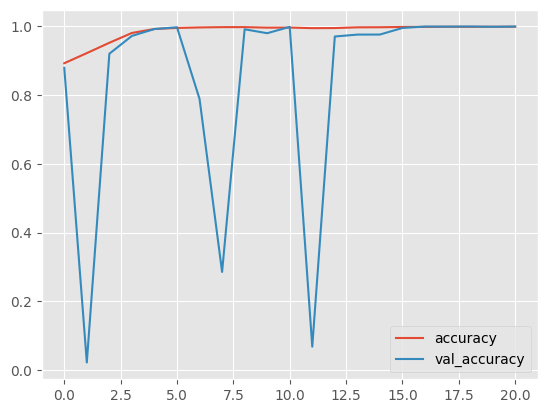

In [502]:
pd.DataFrame(trans.history)[['accuracy','val_accuracy']].plot()

<AxesSubplot:>

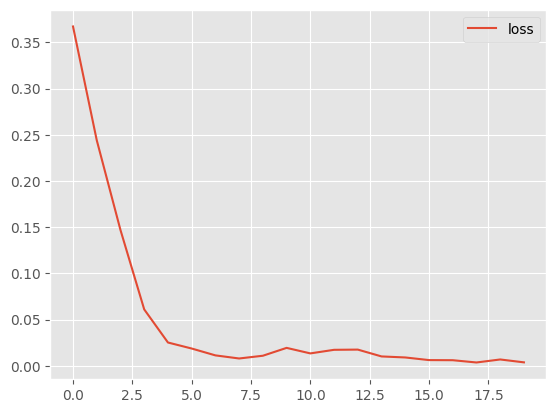

In [472]:
pd.DataFrame(trans.history)[['loss']].plot()

In [496]:
np.array(trans.decoder.layer_embedding.compute_mask(tf.convert_to_tensor(trans.input_y))[0]).sum()

10

In [570]:
a = tf.convert_to_tensor([[1,2,3,0,0],[2,3,4,5,0]])



In [572]:
tf.linalg.band_part(a, num_lower=1000, num_upper=1)

InvalidArgumentError: {{function_node __wrapped__MatrixBandPart_device_/job:localhost/replica:0/task:0/device:CPU:0}} num_lower must be negative or less or equal to number of rows (2) got: 1000 [Op:MatrixBandPart]

In [547]:
def _create_dec_self_attention_mask(decoder_input: tf.Tensor):
    with tf.name_scope('dec_self_attention_mask'):
        batch_size, length = tf.unstack(tf.shape(decoder_input))
        pad_array = tf.equal(decoder_input, 0)  # [batch_size, m_length]
        pad_array = tf.reshape(pad_array, [batch_size, 1, 1, length])

        autoregression_array = tf.logical_not(
            tf.linalg.band_part(tf.ones([length, length], dtype=tf.bool), -1, 0))  # 下三角が False
        autoregression_array = tf.reshape(autoregression_array, [1, 1, length, length])

        return tf.logical_or(pad_array, autoregression_array)

_create_dec_self_attention_mask(a)

<tf.Tensor: shape=(2, 1, 5, 5), dtype=bool, numpy=
array([[[[False,  True,  True,  True,  True],
         [False, False,  True,  True,  True],
         [False, False, False,  True,  True],
         [False, False, False,  True,  True],
         [False, False, False,  True,  True]]],


       [[[False,  True,  True,  True,  True],
         [False, False,  True,  True,  True],
         [False, False, False,  True,  True],
         [False, False, False, False,  True],
         [False, False, False, False,  True]]]])>